In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
class PositionalEmbedding1D(nn.Module):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, seq_len, dim):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, dim))
    
    def forward(self, x):
        """Input has shape `(batch_size, seq_len, emb_dim)`"""
        # (1, 3, 14, 14) + (1, 3, 196) ? wtf
        # ohhh flatten before embedding kek
        return x + self.pos_embedding

In [3]:
class MLP(nn.Module):
    def __init__(self, dim, ff_dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, dim)
        
    def forward(self, x):
        out = self.fc2(F.gelu(self.fc1(x)))
        return out

In [4]:
class MHSA(nn.Module):
    def __init__(self, dim, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.project = nn.Linear(dim, dim)
        
    def forward(self, x): # input shape [b, s, d]
        # split into q, k, v : (query, key, values)
        # expand by h (num heads... hence multi attention)
        
        q, k, v = self.project(x), self.project(x), self.project(x)
        # convert q, k, v -> [b, h, s, w] where h = n_heads
        q = q.view(q.shape[0], self.n_heads, q.shape[1], -1)
        k = k.view(k.shape[0], self.n_heads, k.shape[1], -1)
        v = v.view(v.shape[0], self.n_heads, v.shape[1], -1)
        
        # scaled dot product attention on q, k (queries, keys) then matmul with values
        # matmul + scale
        # [b, h, s, w] @ [b, h, w, s] -> [b, h, s, s]
        k = k.transpose(-2, -1) # swap last two dimensions
        p = torch.matmul(q, k)
        p = p / np.sqrt(k.size(-1)) # where s is the dimension of k

        p = F.softmax(p, dim = -1) # softmax across last dimension
        
        out = torch.matmul(p, v) # [b, h, s, s] @ [b, h, s, w] -> [b, h, s, w]
        out = out.view(out.shape[0], out.shape[2], -1) # [b, s, d]
        return out

In [5]:
# dont need linear and dont need dropout i think
# add after if performance is shit

class Block(nn.Module): # inputs are B, S, D
    def __init__(self, dim, n_heads, ff_dim):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.MHSA = MHSA(dim, n_heads)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        self.mlp_channels = MLP(dim, ff_dim)
        
    def forward(self, x):
        h = self.MHSA(self.norm1(x))
        x = x + h
        h = self.mlp_channels(self.norm2(x))
        x = x + h
        return x

In [6]:
class Transformer(nn.Module):
    def __init__(self, n_layers, dim, n_heads, ff_dim):
        super().__init__()
        self.blocks = nn.ModuleList([Block(dim, n_heads, ff_dim) for _ in range(n_layers)])
    
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

In [7]:
'''
with image 1, 3, 224, 224  and patch encoding of 16x16 we have
((224 - 16) / 16) + 1 = 14
seq len is 14 * 14 bro im trippin bullets
out = (1, 3, 14, 14)
'''

'\nwith image 1, 3, 224, 224  and patch encoding of 16x16 we have\n((224 - 16) / 16) + 1 = 14\nseq len is 14 * 14 bro im trippin bullets\nout = (1, 3, 14, 14)\n'

In [8]:
class ViT(nn.Module):
    def __init__(self, in_channels, dim, fh, fw, n_layers, n_heads, ff_dim, num_classes):
        super().__init__()
        self.fw = fw
        self.fh = fh
        self.patch_encoding = nn.Conv2d(in_channels, dim, kernel_size=(self.fh, self.fw), stride=(self.fh, self.fw))
        # [B, D, FH, FW]
        
        seq_len = 14 * 14
            
        self.positional_embedding = PositionalEmbedding1D(seq_len, dim) # inputs are seq len, dim
        # [B, D, FH, FW]
        
        # flatten into [B, S, D]
        self.Transformer = Transformer(n_layers, dim, n_heads, ff_dim)
        
        # if this doenst work then do it manually
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.head = nn.Linear(dim, num_classes)
        
    def forward(self, x):
        x = self.patch_encoding(x)
        x = x.view(x.shape[0], -1, x.shape[1]) # b, s, d
        x = self.positional_embedding(x) 
        x = self.Transformer(x)
        x = self.norm(x)
        x = x[:, -1, :] # b, s, d -> b, d
        x = self.head(x)
        return x

In [9]:
#hyperparameters
fw = fh = 16
dim = 768
ff_dim = 3072
n_heads = 12
n_layers = 12
in_channels = 3
num_classes = 1000


In [10]:
model = ViT(in_channels, dim, fh, fw, n_layers, n_heads, ff_dim, num_classes)

In [11]:
x = torch.load("b16.pth")

In [12]:
from collections import OrderedDict

In [13]:
d = OrderedDict()

In [14]:
for i, j in x.items():
    if i[:7] == "blocks.":
        newkey = "Transformer." + i
        d[newkey] = j
    else:
        d[i] = j

In [15]:
dd = OrderedDict()

In [16]:
for i, j in d.items():
    if i[21:31] != 'mlp_tokens':
        dd[i] = j

In [17]:
ddd = OrderedDict()

In [18]:
for i, j in dd.items():
    if i[22:32] != 'mlp_tokens':
        ddd[i] = j

In [19]:
# fuck the rest of these weights
model.load_state_dict(ddd, strict=False)

_IncompatibleKeys(missing_keys=['patch_encoding.weight', 'patch_encoding.bias', 'positional_embedding.pos_embedding', 'Transformer.blocks.0.MHSA.project.weight', 'Transformer.blocks.0.MHSA.project.bias', 'Transformer.blocks.1.MHSA.project.weight', 'Transformer.blocks.1.MHSA.project.bias', 'Transformer.blocks.2.MHSA.project.weight', 'Transformer.blocks.2.MHSA.project.bias', 'Transformer.blocks.3.MHSA.project.weight', 'Transformer.blocks.3.MHSA.project.bias', 'Transformer.blocks.4.MHSA.project.weight', 'Transformer.blocks.4.MHSA.project.bias', 'Transformer.blocks.5.MHSA.project.weight', 'Transformer.blocks.5.MHSA.project.bias', 'Transformer.blocks.6.MHSA.project.weight', 'Transformer.blocks.6.MHSA.project.bias', 'Transformer.blocks.7.MHSA.project.weight', 'Transformer.blocks.7.MHSA.project.bias', 'Transformer.blocks.8.MHSA.project.weight', 'Transformer.blocks.8.MHSA.project.bias', 'Transformer.blocks.9.MHSA.project.weight', 'Transformer.blocks.9.MHSA.project.bias', 'Transformer.blocks.10

# load dataset and train

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import sys
import torchvision
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
import os
import cv2

In [21]:
labels = ['street', 'sea', 'mountain', 'glacier', 'forest', 'buildings']

In [22]:
image_size = (224, 224)

In [23]:
class Data(torch.utils.data.Dataset):
    def __init__(self, labels, image_size):
        self.data = []
        self.labels = []
        self.dir = 'D:/Data/intel/seg_train'
        
        i = 0
        for folder in os.listdir(self.dir):
            label = i
            for file in tqdm(os.listdir(os.path.join(self.dir, folder))):
                img_path = os.path.join(os.path.join(self.dir, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.resize(image, image_size)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = np.reshape(image, [3, 224, 224])
                 
                # Append the image and its corresponding label to the output
                self.data.append(image)
                self.labels.append(label)
            i += 1
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [24]:
import matplotlib.pyplot as plt

In [25]:
test = cv2.imread('D:/Data/intel/seg_train/buildings/0.jpg')

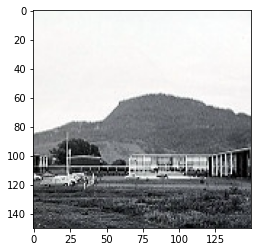

In [26]:
plt.imshow(test)

In [27]:
data = Data(labels, image_size)

100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:06<00:00, 387.01it/s]


In [28]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [29]:
# this step was fucking aids bruh
lol = torch.LongTensor(data.labels)
one_hot = F.one_hot(lol, 6)
resized_labels = torch.cat([one_hot, torch.zeros(14034, 994)], axis=1)
data.labels = resized_labels

In [30]:
# train, val = torch.utils.data.random_split(x, [12630, 1404])
train, val = torch.utils.data.random_split(data, [12630, 1404])

In [31]:
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=16)
valloader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=16)

In [32]:
device = torch.device('cuda')
import torch.optim as optim

In [33]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [34]:
# has softmax in it
loss = nn.CrossEntropyLoss()

In [35]:
model.train()

ViT(
  (patch_encoding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (Transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (MHSA): MHSA(
          (project): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp_channels): MLP(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (MHSA): MHSA(
          (project): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp_channels): MLP(
          (fc1): Linear(in_features=768, out_features=3072, bias=

In [36]:
# this thing is probably gonna overfit but full send i sleep and check reuslts in morning

In [37]:
training_losses = []
val_losses = []
avg_training_losses = []
avg_val_losses = []

In [38]:
losses = []
for e in tqdm(range(100)):
    for x, y in trainloader:
        torch.cuda.empty_cache()
        x, y = x.to(device), y.to(device)
        x = x.float()
        
        # train step
        optimizer.zero_grad()
        y_pred = model(x)
        l = loss(y_pred, y)
        t_l = l.detach().cpu().numpy()
        l.backward()
        optimizer.step()
        
        training_losses.append(t_l)
        
    for i, j in valloader:
        # no optim zero grad, step, l.backward
        x, y = x.to(device), y.to(device)
        x = x.float()
        
        y_pred = model(x)
        ll = loss(y_pred, y)
        v_l = ll.detach().cpu().numpy()
        
        val_losses.append(v_l)
        
    avg_training_losses.append(np.mean(training_losses))
    avg_val_losses.append(np.mean(val_losses))
        
    print(f' *** Training Loss: {np.mean(training_losses)}, Validation Loss: {np.mean(val_losses)} *** ')

  1%|▊                                                                              | 1/100 [03:50<6:20:11, 230.42s/it]

 *** Training Loss: 1.3666573762893677, Validation Loss: 1.2283785343170166 *** 


  2%|█▌                                                                             | 2/100 [07:40<6:15:36, 229.97s/it]

 *** Training Loss: 1.259026050567627, Validation Loss: 1.304595947265625 *** 


  3%|██▎                                                                            | 3/100 [11:28<6:10:40, 229.28s/it]

 *** Training Loss: 1.1819167137145996, Validation Loss: 1.06917405128479 *** 


  4%|███▏                                                                           | 4/100 [15:17<6:06:50, 229.28s/it]

 *** Training Loss: 1.1146107912063599, Validation Loss: 0.9957960247993469 *** 


  5%|███▉                                                                           | 5/100 [19:07<6:03:00, 229.27s/it]

 *** Training Loss: 1.047501564025879, Validation Loss: 0.8497501611709595 *** 


  6%|████▋                                                                          | 6/100 [22:56<5:59:28, 229.45s/it]

 *** Training Loss: 0.9773978590965271, Validation Loss: 0.7391743659973145 *** 


  7%|█████▌                                                                         | 7/100 [26:46<5:55:52, 229.60s/it]

 *** Training Loss: 0.9067740440368652, Validation Loss: 0.6697086691856384 *** 


  8%|██████▎                                                                        | 8/100 [30:36<5:52:13, 229.71s/it]

 *** Training Loss: 0.8372637629508972, Validation Loss: 0.5996837615966797 *** 


  9%|███████                                                                        | 9/100 [34:26<5:48:28, 229.76s/it]

 *** Training Loss: 0.7721478939056396, Validation Loss: 0.5349938869476318 *** 


 10%|███████▊                                                                      | 10/100 [38:16<5:44:42, 229.80s/it]

 *** Training Loss: 0.7127896547317505, Validation Loss: 0.4824185371398926 *** 


 11%|████████▌                                                                     | 11/100 [42:06<5:40:58, 229.87s/it]

 *** Training Loss: 0.6613919734954834, Validation Loss: 0.44265714287757874 *** 


 12%|█████████▎                                                                    | 12/100 [45:56<5:37:17, 229.98s/it]

 *** Training Loss: 0.6176672577857971, Validation Loss: 0.4067600667476654 *** 


 13%|██████████▏                                                                   | 13/100 [49:46<5:33:31, 230.02s/it]

 *** Training Loss: 0.5776761174201965, Validation Loss: 0.37577390670776367 *** 


 14%|██████████▉                                                                   | 14/100 [53:36<5:29:41, 230.02s/it]

 *** Training Loss: 0.5417178869247437, Validation Loss: 0.3498804569244385 *** 


 15%|███████████▋                                                                  | 15/100 [57:26<5:25:47, 229.97s/it]

 *** Training Loss: 0.511419415473938, Validation Loss: 0.3265710473060608 *** 


 16%|████████████▏                                                               | 16/100 [1:01:16<5:22:00, 230.00s/it]

 *** Training Loss: 0.48416420817375183, Validation Loss: 0.30666545033454895 *** 


 17%|████████████▉                                                               | 17/100 [1:05:06<5:18:11, 230.02s/it]

 *** Training Loss: 0.46092191338539124, Validation Loss: 0.2886303663253784 *** 


 18%|█████████████▋                                                              | 18/100 [1:08:56<5:14:22, 230.03s/it]

 *** Training Loss: 0.4394306540489197, Validation Loss: 0.27259624004364014 *** 


 19%|██████████████▍                                                             | 19/100 [1:12:46<5:10:29, 230.00s/it]

 *** Training Loss: 0.4186980426311493, Validation Loss: 0.25878649950027466 *** 


 20%|███████████████▏                                                            | 20/100 [1:16:36<5:06:34, 229.93s/it]

 *** Training Loss: 0.4028136134147644, Validation Loss: 0.24587440490722656 *** 


 21%|███████████████▉                                                            | 21/100 [1:20:26<5:02:39, 229.87s/it]

 *** Training Loss: 0.3857629895210266, Validation Loss: 0.23416763544082642 *** 


 22%|████████████████▋                                                           | 22/100 [1:24:16<4:58:50, 229.88s/it]

 *** Training Loss: 0.37045806646347046, Validation Loss: 0.2235272377729416 *** 


 23%|█████████████████▍                                                          | 23/100 [1:28:06<4:55:01, 229.89s/it]

 *** Training Loss: 0.35596802830696106, Validation Loss: 0.21383045613765717 *** 


 24%|██████████████████▏                                                         | 24/100 [1:31:56<4:51:14, 229.93s/it]

 *** Training Loss: 0.344204843044281, Validation Loss: 0.20492100715637207 *** 


 25%|███████████████████                                                         | 25/100 [1:35:46<4:47:24, 229.92s/it]

 *** Training Loss: 0.3320154547691345, Validation Loss: 0.19711367785930634 *** 


 26%|███████████████████▊                                                        | 26/100 [1:39:35<4:43:30, 229.88s/it]

 *** Training Loss: 0.3212422728538513, Validation Loss: 0.18957377970218658 *** 


 27%|████████████████████▌                                                       | 27/100 [1:43:25<4:39:38, 229.84s/it]

 *** Training Loss: 0.3107600212097168, Validation Loss: 0.18257321417331696 *** 


 28%|█████████████████████▎                                                      | 28/100 [1:47:15<4:35:46, 229.82s/it]

 *** Training Loss: 0.30103757977485657, Validation Loss: 0.17606279253959656 *** 


 29%|██████████████████████                                                      | 29/100 [1:51:05<4:32:00, 229.86s/it]

 *** Training Loss: 0.2923266291618347, Validation Loss: 0.1699918806552887 *** 


 30%|██████████████████████▊                                                     | 30/100 [1:54:55<4:28:12, 229.89s/it]

 *** Training Loss: 0.2841993272304535, Validation Loss: 0.1643676906824112 *** 


 31%|███████████████████████▌                                                    | 31/100 [1:58:45<4:24:20, 229.86s/it]

 *** Training Loss: 0.27612343430519104, Validation Loss: 0.1593925654888153 *** 


 32%|████████████████████████▎                                                   | 32/100 [2:02:36<4:21:07, 230.40s/it]

 *** Training Loss: 0.26845893263816833, Validation Loss: 0.1544209122657776 *** 


 33%|█████████████████████████                                                   | 33/100 [2:06:27<4:17:22, 230.48s/it]

 *** Training Loss: 0.2614477872848511, Validation Loss: 0.1497509926557541 *** 


 34%|█████████████████████████▊                                                  | 34/100 [2:10:20<4:14:28, 231.34s/it]

 *** Training Loss: 0.25506195425987244, Validation Loss: 0.14537298679351807 *** 


 35%|██████████████████████████▌                                                 | 35/100 [2:14:16<4:12:08, 232.74s/it]

 *** Training Loss: 0.2508266568183899, Validation Loss: 0.14135964214801788 *** 


 36%|███████████████████████████▎                                                | 36/100 [2:18:07<4:07:46, 232.29s/it]

 *** Training Loss: 0.24413293600082397, Validation Loss: 0.13744708895683289 *** 


 37%|████████████████████████████                                                | 37/100 [2:21:58<4:03:25, 231.84s/it]

 *** Training Loss: 0.238790825009346, Validation Loss: 0.13376830518245697 *** 


 38%|████████████████████████████▉                                               | 38/100 [2:25:49<3:59:10, 231.45s/it]

 *** Training Loss: 0.23311325907707214, Validation Loss: 0.13026869297027588 *** 


 39%|█████████████████████████████▋                                              | 39/100 [2:29:39<3:55:02, 231.19s/it]

 *** Training Loss: 0.22765295207500458, Validation Loss: 0.1269286572933197 *** 


 40%|██████████████████████████████▍                                             | 40/100 [2:33:30<3:50:59, 231.00s/it]

 *** Training Loss: 0.2229723185300827, Validation Loss: 0.12376007437705994 *** 


 41%|███████████████████████████████▏                                            | 41/100 [2:37:21<3:47:01, 230.87s/it]

 *** Training Loss: 0.21860122680664062, Validation Loss: 0.12080744653940201 *** 


 42%|███████████████████████████████▉                                            | 42/100 [2:41:11<3:43:07, 230.82s/it]

 *** Training Loss: 0.21403947472572327, Validation Loss: 0.11793435364961624 *** 


 43%|████████████████████████████████▋                                           | 43/100 [2:45:02<3:39:13, 230.77s/it]

 *** Training Loss: 0.20931825041770935, Validation Loss: 0.11523927003145218 *** 


 44%|█████████████████████████████████▍                                          | 44/100 [2:48:53<3:35:23, 230.78s/it]

 *** Training Loss: 0.20532584190368652, Validation Loss: 0.11262050271034241 *** 


 45%|██████████████████████████████████▏                                         | 45/100 [2:52:43<3:31:30, 230.73s/it]

 *** Training Loss: 0.2015000432729721, Validation Loss: 0.11012173444032669 *** 


 46%|██████████████████████████████████▉                                         | 46/100 [2:56:34<3:27:34, 230.65s/it]

 *** Training Loss: 0.1974240094423294, Validation Loss: 0.10778305679559708 *** 


 47%|███████████████████████████████████▋                                        | 47/100 [3:00:24<3:23:42, 230.60s/it]

 *** Training Loss: 0.193956196308136, Validation Loss: 0.10558220744132996 *** 


 48%|████████████████████████████████████▍                                       | 48/100 [3:04:15<3:19:51, 230.60s/it]

 *** Training Loss: 0.19047728180885315, Validation Loss: 0.10338336229324341 *** 


 49%|█████████████████████████████████████▏                                      | 49/100 [3:08:05<3:16:00, 230.60s/it]

 *** Training Loss: 0.18682974576950073, Validation Loss: 0.10127943754196167 *** 


 50%|██████████████████████████████████████                                      | 50/100 [3:11:56<3:12:09, 230.59s/it]

 *** Training Loss: 0.18333913385868073, Validation Loss: 0.09925385564565659 *** 


 51%|██████████████████████████████████████▊                                     | 51/100 [3:15:47<3:08:19, 230.61s/it]

 *** Training Loss: 0.18041545152664185, Validation Loss: 0.09734829515218735 *** 


 52%|███████████████████████████████████████▌                                    | 52/100 [3:19:37<3:04:27, 230.57s/it]

 *** Training Loss: 0.1774851679801941, Validation Loss: 0.09548080712556839 *** 


 53%|████████████████████████████████████████▎                                   | 53/100 [3:23:28<3:00:34, 230.53s/it]

 *** Training Loss: 0.1742779016494751, Validation Loss: 0.09367997944355011 *** 


 54%|█████████████████████████████████████████                                   | 54/100 [3:27:18<2:56:44, 230.54s/it]

 *** Training Loss: 0.171409472823143, Validation Loss: 0.09194566309452057 *** 


 55%|█████████████████████████████████████████▊                                  | 55/100 [3:31:09<2:52:55, 230.56s/it]

 *** Training Loss: 0.1689562052488327, Validation Loss: 0.09027442336082458 *** 


 56%|██████████████████████████████████████████▌                                 | 56/100 [3:34:59<2:49:02, 230.51s/it]

 *** Training Loss: 0.16634827852249146, Validation Loss: 0.08866293728351593 *** 


 57%|███████████████████████████████████████████▎                                | 57/100 [3:38:49<2:45:08, 230.44s/it]

 *** Training Loss: 0.16376975178718567, Validation Loss: 0.08710773289203644 *** 


 58%|████████████████████████████████████████████                                | 58/100 [3:42:40<2:41:17, 230.43s/it]

 *** Training Loss: 0.16107791662216187, Validation Loss: 0.0856069028377533 *** 


 59%|████████████████████████████████████████████▊                               | 59/100 [3:46:30<2:37:27, 230.42s/it]

 *** Training Loss: 0.15878647565841675, Validation Loss: 0.08418556302785873 *** 


 60%|█████████████████████████████████████████████▌                              | 60/100 [3:50:21<2:33:38, 230.47s/it]

 *** Training Loss: 0.15638013184070587, Validation Loss: 0.08280767500400543 *** 


 61%|██████████████████████████████████████████████▎                             | 61/100 [3:54:11<2:29:48, 230.48s/it]

 *** Training Loss: 0.1543114334344864, Validation Loss: 0.0814720094203949 *** 


 62%|███████████████████████████████████████████████                             | 62/100 [3:58:02<2:25:58, 230.49s/it]

 *** Training Loss: 0.15206606686115265, Validation Loss: 0.08015795052051544 *** 


 63%|███████████████████████████████████████████████▉                            | 63/100 [4:01:53<2:22:11, 230.57s/it]

 *** Training Loss: 0.14995893836021423, Validation Loss: 0.07889381796121597 *** 


 64%|████████████████████████████████████████████████▋                           | 64/100 [4:05:43<2:18:20, 230.56s/it]

 *** Training Loss: 0.14790207147598267, Validation Loss: 0.07766124606132507 *** 


 65%|█████████████████████████████████████████████████▍                          | 65/100 [4:09:34<2:14:27, 230.51s/it]

 *** Training Loss: 0.14580374956130981, Validation Loss: 0.07646646350622177 *** 


 66%|██████████████████████████████████████████████████▏                         | 66/100 [4:13:24<2:10:35, 230.45s/it]

 *** Training Loss: 0.14396429061889648, Validation Loss: 0.07531872391700745 *** 


 67%|██████████████████████████████████████████████████▉                         | 67/100 [4:17:14<2:06:44, 230.44s/it]

 *** Training Loss: 0.14205054938793182, Validation Loss: 0.07423669099807739 *** 


 68%|███████████████████████████████████████████████████▋                        | 68/100 [4:21:05<2:02:53, 230.43s/it]

 *** Training Loss: 0.140310600399971, Validation Loss: 0.0731523185968399 *** 


 69%|████████████████████████████████████████████████████▍                       | 69/100 [4:24:55<1:59:02, 230.40s/it]

 *** Training Loss: 0.1384526789188385, Validation Loss: 0.07209214568138123 *** 


 70%|█████████████████████████████████████████████████████▏                      | 70/100 [4:28:45<1:55:10, 230.37s/it]

 *** Training Loss: 0.1367044299840927, Validation Loss: 0.07107096165418625 *** 


 71%|█████████████████████████████████████████████████████▉                      | 71/100 [4:32:36<1:51:19, 230.33s/it]

 *** Training Loss: 0.13511711359024048, Validation Loss: 0.07017570734024048 *** 


 72%|██████████████████████████████████████████████████████▋                     | 72/100 [4:36:26<1:47:27, 230.28s/it]

 *** Training Loss: 0.13340389728546143, Validation Loss: 0.06920325756072998 *** 


 73%|███████████████████████████████████████████████████████▍                    | 73/100 [4:40:16<1:43:38, 230.31s/it]

 *** Training Loss: 0.13165141642093658, Validation Loss: 0.06825527548789978 *** 


 74%|████████████████████████████████████████████████████████▏                   | 74/100 [4:44:06<1:39:48, 230.33s/it]

 *** Training Loss: 0.13026899099349976, Validation Loss: 0.06733804196119308 *** 


 75%|█████████████████████████████████████████████████████████                   | 75/100 [4:47:57<1:35:57, 230.31s/it]

 *** Training Loss: 0.12870880961418152, Validation Loss: 0.06644117087125778 *** 


 76%|█████████████████████████████████████████████████████████▊                  | 76/100 [4:51:47<1:32:07, 230.31s/it]

 *** Training Loss: 0.1272018998861313, Validation Loss: 0.06557318568229675 *** 


 77%|██████████████████████████████████████████████████████████▌                 | 77/100 [4:55:37<1:28:17, 230.31s/it]

 *** Training Loss: 0.1257663071155548, Validation Loss: 0.06472476571798325 *** 


 78%|███████████████████████████████████████████████████████████▎                | 78/100 [4:59:28<1:24:26, 230.29s/it]

 *** Training Loss: 0.12433979660272598, Validation Loss: 0.06389521062374115 *** 


 79%|████████████████████████████████████████████████████████████                | 79/100 [5:03:18<1:20:36, 230.30s/it]

 *** Training Loss: 0.12304466962814331, Validation Loss: 0.06309463083744049 *** 


 80%|████████████████████████████████████████████████████████████▊               | 80/100 [5:07:08<1:16:46, 230.31s/it]

 *** Training Loss: 0.12166056782007217, Validation Loss: 0.06230597943067551 *** 


 81%|█████████████████████████████████████████████████████████████▌              | 81/100 [5:10:58<1:12:55, 230.27s/it]

 *** Training Loss: 0.1202545240521431, Validation Loss: 0.06153702735900879 *** 


 82%|██████████████████████████████████████████████████████████████▎             | 82/100 [5:14:49<1:09:04, 230.26s/it]

 *** Training Loss: 0.11909465491771698, Validation Loss: 0.060786619782447815 *** 


 83%|███████████████████████████████████████████████████████████████             | 83/100 [5:18:39<1:05:14, 230.25s/it]

 *** Training Loss: 0.11780574172735214, Validation Loss: 0.060054268687963486 *** 


 84%|███████████████████████████████████████████████████████████████▊            | 84/100 [5:22:29<1:01:23, 230.21s/it]

 *** Training Loss: 0.11662407964468002, Validation Loss: 0.05933934822678566 *** 


 85%|██████████████████████████████████████████████████████████████████▎           | 85/100 [5:26:19<57:32, 230.18s/it]

 *** Training Loss: 0.1153898686170578, Validation Loss: 0.058658625930547714 *** 


 86%|███████████████████████████████████████████████████████████████████           | 86/100 [5:30:09<53:42, 230.16s/it]

 *** Training Loss: 0.11418279260396957, Validation Loss: 0.05797886475920677 *** 


 87%|███████████████████████████████████████████████████████████████████▊          | 87/100 [5:33:59<49:51, 230.09s/it]

 *** Training Loss: 0.11312844604253769, Validation Loss: 0.057321660220623016 *** 


 88%|████████████████████████████████████████████████████████████████████▋         | 88/100 [5:37:49<46:00, 230.07s/it]

 *** Training Loss: 0.11191843450069427, Validation Loss: 0.056673914194107056 *** 


 89%|█████████████████████████████████████████████████████████████████████▍        | 89/100 [5:41:39<42:10, 230.08s/it]

 *** Training Loss: 0.1107947900891304, Validation Loss: 0.056038156151771545 *** 


 90%|██████████████████████████████████████████████████████████████████████▏       | 90/100 [5:45:29<38:20, 230.10s/it]

 *** Training Loss: 0.10979539901018143, Validation Loss: 0.05541559308767319 *** 


 91%|██████████████████████████████████████████████████████████████████████▉       | 91/100 [5:49:19<34:30, 230.10s/it]

 *** Training Loss: 0.10873531550168991, Validation Loss: 0.0548076368868351 *** 


 92%|███████████████████████████████████████████████████████████████████████▊      | 92/100 [5:53:10<30:40, 230.10s/it]

 *** Training Loss: 0.1075994223356247, Validation Loss: 0.05422225594520569 *** 


 93%|████████████████████████████████████████████████████████████████████████▌     | 93/100 [5:57:00<26:50, 230.10s/it]

 *** Training Loss: 0.1066657155752182, Validation Loss: 0.053646501153707504 *** 


 94%|█████████████████████████████████████████████████████████████████████████▎    | 94/100 [6:00:50<23:00, 230.12s/it]

 *** Training Loss: 0.10558240115642548, Validation Loss: 0.053075797855854034 *** 


 95%|██████████████████████████████████████████████████████████████████████████    | 95/100 [6:04:40<19:10, 230.15s/it]

 *** Training Loss: 0.10454925149679184, Validation Loss: 0.052518270909786224 *** 


 96%|██████████████████████████████████████████████████████████████████████████▉   | 96/100 [6:08:33<15:23, 230.85s/it]

 *** Training Loss: 0.103683702647686, Validation Loss: 0.05198528617620468 *** 


 97%|███████████████████████████████████████████████████████████████████████████▋  | 97/100 [6:12:29<11:37, 232.57s/it]

 *** Training Loss: 0.10271152853965759, Validation Loss: 0.05144943669438362 *** 


 98%|████████████████████████████████████████████████████████████████████████████▍ | 98/100 [6:16:26<07:47, 233.99s/it]

 *** Training Loss: 0.10169506818056107, Validation Loss: 0.05092460662126541 *** 


 99%|█████████████████████████████████████████████████████████████████████████████▏| 99/100 [6:20:24<03:55, 235.14s/it]

 *** Training Loss: 0.10069575905799866, Validation Loss: 0.050410255789756775 *** 


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [6:24:22<00:00, 230.62s/it]

 *** Training Loss: 0.09971313178539276, Validation Loss: 0.04990623518824577 *** 


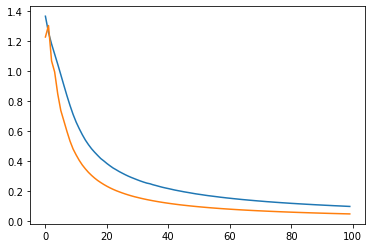

In [39]:
plt.plot(avg_training_losses)
plt.plot(avg_val_losses)

In [40]:
model.eval()

ViT(
  (patch_encoding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (Transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (MHSA): MHSA(
          (project): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp_channels): MLP(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (MHSA): MHSA(
          (project): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp_channels): MLP(
          (fc1): Linear(in_features=768, out_features=3072, bias=

In [41]:
a, b = [], []

for x, y in valloader:
    x, y = x.to(device), y.to(device)
    x = x.float()
    y_pred = model(x)
    y_pred, y = y_pred.detach().cpu().numpy(), y.detach().cpu().numpy()
    yes, sir = np.argmax(y_pred, axis=1), np.argmax(y, axis=1)
    a.append(yes)
    b.append(sir)

In [42]:
len(trainloader)

790

In [45]:
len(valloader)

88

In [43]:
count = 0
for i, j in zip(a, b):
    for k, l in zip(i, j):
        if k == l:
            count += 1

In [46]:
# it overfit
count/1408

0.6463068181818182

* yo thats pretty insane for 10 epochs of training wtf
* i used a bare minimum cnn architecture and it got 50% accuracy a while ago on this dataset and it trained on 90% 10% and this one trained on 50 50 lmao
* this is also highly unoptimized i just did the bare minimum to try to get it to work
* its pretty dope how it could learn hella fast from having 1000 num classes parameters tho

## to do:
#### figure out a cleaner way to load state dict from pretrained weights
#### figure out how to fine tune like a non idiot
### clean up all code and refactor into clean structure

In [ ]:
# [0, 3, 3, 0, 1, 1, 0, 2, 3, 3, 2, 0, 5, 4, 1, 0]
# [0, 3, 3, 1, 0, 1, 5, 2, 2, 2, 3, 0, 1, 4, 1, 0]

In [47]:
a

[array([0, 3, 3, 1, 0, 1, 5, 2, 2, 2, 3, 0, 1, 4, 1, 0], dtype=int64),
 array([5, 0, 0, 3, 2, 3, 4, 0, 5, 4, 3, 0, 5, 5, 4, 1], dtype=int64),
 array([5, 2, 0, 5, 0, 4, 4, 5, 4, 2, 4, 5, 4, 0, 2, 0], dtype=int64),
 array([0, 3, 0, 3, 5, 4, 1, 5, 5, 5, 1, 3, 0, 5, 3, 4], dtype=int64),
 array([4, 2, 3, 2, 0, 5, 1, 0, 4, 3, 5, 1, 2, 3, 5, 0], dtype=int64),
 array([2, 1, 0, 5, 3, 3, 5, 5, 2, 5, 5, 5, 2, 4, 5, 5], dtype=int64),
 array([3, 2, 2, 1, 4, 1, 5, 5, 5, 1, 2, 3, 2, 3, 5, 2], dtype=int64),
 array([2, 3, 4, 0, 4, 3, 2, 1, 1, 3, 3, 4, 5, 2, 2, 5], dtype=int64),
 array([2, 0, 0, 4, 5, 2, 3, 1, 2, 2, 0, 3, 2, 1, 2, 3], dtype=int64),
 array([1, 4, 5, 0, 5, 4, 1, 3, 4, 3, 0, 0, 1, 1, 2, 0], dtype=int64),
 array([3, 0, 3, 2, 4, 2, 3, 2, 5, 5, 5, 5, 4, 1, 5, 1], dtype=int64),
 array([0, 0, 1, 4, 1, 4, 2, 0, 3, 2, 4, 5, 4, 2, 1, 5], dtype=int64),
 array([2, 4, 3, 2, 2, 3, 1, 5, 5, 3, 1, 3, 4, 4, 2, 3], dtype=int64),
 array([0, 5, 2, 4, 5, 5, 1, 1, 3, 1, 5, 3, 2, 3, 1, 0], dtype=int64),
 array

In [48]:
b

[array([0, 3, 3, 0, 1, 1, 0, 2, 3, 3, 2, 0, 5, 4, 1, 0], dtype=int64),
 array([5, 0, 0, 2, 2, 3, 4, 5, 1, 4, 3, 0, 5, 5, 3, 1], dtype=int64),
 array([5, 2, 0, 5, 0, 4, 4, 5, 2, 2, 4, 5, 4, 0, 4, 5], dtype=int64),
 array([0, 3, 4, 0, 2, 0, 5, 1, 5, 5, 4, 0, 4, 5, 3, 4], dtype=int64),
 array([3, 4, 3, 2, 0, 5, 1, 0, 4, 5, 3, 1, 2, 4, 5, 5], dtype=int64),
 array([2, 1, 4, 4, 3, 3, 5, 5, 2, 5, 5, 5, 3, 4, 1, 5], dtype=int64),
 array([3, 2, 2, 1, 2, 4, 1, 0, 5, 3, 2, 2, 2, 3, 5, 2], dtype=int64),
 array([2, 0, 4, 3, 4, 3, 4, 1, 1, 3, 3, 4, 5, 2, 2, 5], dtype=int64),
 array([2, 1, 0, 4, 5, 3, 3, 1, 2, 2, 0, 2, 2, 4, 2, 3], dtype=int64),
 array([1, 4, 5, 5, 4, 4, 1, 4, 2, 3, 3, 0, 2, 1, 4, 0], dtype=int64),
 array([4, 0, 3, 4, 4, 2, 3, 2, 1, 0, 5, 1, 4, 1, 3, 1], dtype=int64),
 array([2, 3, 1, 2, 1, 4, 2, 0, 3, 3, 4, 5, 4, 4, 1, 5], dtype=int64),
 array([3, 2, 3, 2, 3, 4, 1, 5, 5, 3, 1, 4, 4, 4, 3, 4], dtype=int64),
 array([0, 5, 2, 5, 5, 1, 1, 1, 3, 1, 5, 4, 2, 3, 0, 5], dtype=int64),
 array